In [16]:
from sympy import var
from sympy import solve
import numpy as np
from scipy.optimize import fsolve
import pandas as pd
from matplotlib import pyplot as plt
import csv
import sys
from scipy.integrate import odeint

def vectorfield(w, p):
    """
    Defines the differential equations for the Homeostatic Expansion Project.
    We will use fsolve to try to find the where the R, N, T, and I populations lie when they reach equilibrium.
    It tries to find when:
        dRdt(I,R) = 0
        dNdt(N,R) = 0
        dTdt(R,I,T) = 0
        dTdt(T,R,I) = 0
    For the values of R, N, T, I
    We are looking for the roots

    Arguments:
        w :  vector of the state variables:
                  w = [R, N, T, I]
        p :  vector of the parameters:
                  p = [alpha, Thy, Thy_max, epsilon, a, c, b_R, mu, beta, z, g, b_T, e_T, e_R, f, kA, n, d]
                  
    Below are the parameter definitions
    ############
    #  Thymus  #
    ############
    alpha = 0.006 #------------ T Regulatory Cells
    mu = 60   #---------- Naive T cells
    Thy = 1 #------------ Size of the thymus
    Thy_max = 1 #------- Max size of the thymus

    #########################################
    #  Naive T cell Differentiation Rates   #
    #########################################
    c = 0.01 #--------To T regulatory Cells
    beta = 10 #------ To activated T cells

    ###########
    #  Tregs  #
    ###########
    epsilon = 1 #------------T regulatory cell Self replication
    z       = 1 #------- Strength of suppression on Naive T cell differention to activation
    n       = 1 #hill coefficient
    # kA      = 10 #halfSaturationRate 

    ##############################################
    #  IL-2 Cytokine Expression and Consumption  #
    ##############################################
    d = 0.034 #------- T Cell Expression #This is the value that we want to change.
    a = 0.1   #------------Activated T cells
    e_T = 0.03 #0.01 #------ T Cell Consumption Rate
    e_R = 0.03 #0.01 #------ T Reg Consumption Rate

    ##################
    #  Death Rates   #
    ##################
    g = 0.01 #-----------Naive T cells
    b_T = 0.1 #-----------Activated T cells
    b_R = 0.1 #----------Regulatory T Cells
    f = 1 #-------------IL-2 Cytokine
    """
    N, T, R, I = w #Values here should be from the steady states found earlier
    alpha, Thy, Thy_max, epsilon, a, c, b_R, mu, beta, z, g, b_T, d, e_T, e_R, f, kA, n = p
   
    
    Nf = mu*(Thy/Thy_max) - beta*N*(1/(1+(R/kA)**n)) - c*N - g*N
    Tf = beta*N*(1/(1+(R/kA)**n)) + a*I*T - b_T*T
    Rf = alpha*(Thy/Thy_max) + epsilon*a*I*R + c*N - b_R*R
    If = d*T - e_T*T - e_R*R - f*I   
         
    return [Nf, Tf, Rf, If]





def ModelV4(w,t,p):
    """
    Similar to vectorfield. 
    The only difference is that this one takes time points where the equations need to be solve for. 

    """
    N, T, R, I = w #Values here should be from the steady states found earlier
    alpha, Thy, Thy_max, epsilon, a, c, b_R, mu, beta, z, g, b_T, d, e_T, e_R, f, kA, n = p
   
    
    Nf = mu*(Thy/Thy_max) - beta*N*(1/(1+(R/kA)**n)) - c*N - g*N
    Tf = beta*N*(1/(1+(R/kA)**n)) + a*I*T - b_T*T
    Rf = alpha*(Thy/Thy_max) + epsilon*a*I*R + c*N - b_R*R
    If = d*T - e_T*I*T - e_R*I*R - f*I   
         
    return [Nf, Tf, Rf, If]





def Speculator(pmin, pmax, step, Pname, Ploc):
    """
    FILE - must be in the same folder as this file
    
    This function will take the parameter ranges that you want to find equilbrium points for, creating plots
    
    This is the order that we will be using the parameters. Use this order ALL THE TIME
    [alpha, Thy, Thy_max, epsilon, a, c, b_R, mu, beta, z, g, b_T, d, e_T, e_R, f, kA, n]
    
    OUTPUT:
    The output of all information to be used in the future will be saved in the 'Asiago' variable.
    Asiago[0:18] - Original parameters used

    Asiago[18] - Equilbrium points saved already in the CSV file 

    Asiago[19] - Parameter

    Asiago[20] - The next entry in the csv parameter file
    Asiago[21] - Which parameter entry was used to make the decision
    """
    #Grabs the parameter values from the CSV file
    ParSet = pd.read_csv("Parameters.csv")    
    Parm = ParSet.iloc[Ploc, 0:18]
    
    # Will hold individual parameters
    Gouda = [Parm[0], Parm[1], Parm[2], Parm[3], Parm[4], Parm[5], Parm[6], Parm[7], Parm[8], Parm[9], Parm[10], 
             Parm[11], Parm[12], Parm[13], Parm[14], Parm[15], Parm[16], Parm[17]]
    #Parameter locations
    Brie = {'alpha': 0, 'Thy': 1, 'Thy_max': 2, 'epsilon': 3, 'a': 4, 'c': 5,
            'b_R': 6, 'mu': 7, 'beta': 8, 'z': 9, 'g': 10, 'b_T': 11, 'd': 12,
            'e_T': 13, 'e_R': 14, 'f': 15, 'kA': 16, 'n':17}
    
    #columsn 20 - 24 are the equilbrium points/initial conditions
    w0 = ParSet.iloc[Ploc, 20:24]
    w0 = [w0[0], w0[1], w0[2], w0[3]]
    
    NextEntry = ParSet['EntryNumber'].max() + 1
    
    #A list of values to be tested for the desired parameter
    dRange = np.linspace(pmin, pmax, step)
    dRange = np.around(dRange, 4)
    
    #The dataframe that will hold the equilbrium results
    EquilibriumPoints = pd.DataFrame(columns = ['N', 'T', 'R', 'I', Pname]) #appending i to the end eq array
    
    for i in dRange:
        Gouda[Brie[Pname]] = i #Current value of the d parameter
        eq = fsolve(vectorfield, w0, args=(Gouda)) #Findst the roots of the equations
        eq = np.append(eq, i) #Adds the parameters to the eq array
        EquilibriumPoints.loc[len(EquilibriumPoints)] = eq.tolist() #Adds the row of data to the bottom of the EquilibriumPoints dataframe. eq converted to list
    
    #Time to plot
    
    fig = plt.figure(figsize=(30,20))

    #Plotting Treg results
    Rp = fig.add_subplot(223)
    Rp.plot (EquilibriumPoints[Pname], EquilibriumPoints['R'], 'b-')
    Rp.set_xlabel('Value of the {} parameter'.format(Pname), fontsize = 30)
    Rp.set_ylabel('Tregs', fontsize = 30)
    Rp.set_title('T Regulatory Cells', fontsize = 30)
    Rp.tick_params(axis="x", labelsize=25)
    Rp.tick_params(axis="y", labelsize=25)

    #Naive T cells
    Np = fig.add_subplot(221)
    Np.plot (EquilibriumPoints[Pname], EquilibriumPoints['N'], 'b-')
    Np.set_xlabel('Value of the {} parameter'.format(Pname), fontsize = 30)
    Np.set_ylabel('Naive T cells', fontsize = 30)
    Np.set_title('Naive T cells', fontsize = 30)
    Np.tick_params(axis="x", labelsize=25)
    Np.tick_params(axis="y", labelsize=25)

    #Activated T cells
    Tp = fig.add_subplot(222)
    Tp.plot (EquilibriumPoints[Pname], EquilibriumPoints['T'], 'b-')
    Tp.set_xlabel('Value of the {} parameter'.format(Pname), fontsize = 30)
    Tp.set_ylabel('Activated T cells', fontsize = 30)
    Tp.set_title('Activated T cells', fontsize = 30)
    Tp.tick_params(axis="x", labelsize=25)
    Tp.tick_params(axis="y", labelsize=25)

    #IL-2 Cytokine
    Ip = fig.add_subplot(224)
    Ip.plot (EquilibriumPoints[Pname], EquilibriumPoints['I'], 'b-')
    Ip.set_xlabel('Value of the {} parameter'.format(Pname), fontsize = 30)
    Ip.set_ylabel('IL-2', fontsize = 30)
    Ip.set_title('IL-2', fontsize = 30)
    Ip.tick_params(axis="x", labelsize=25)
    Ip.tick_params(axis="y", labelsize=25)
    
    #All information saved into the Asiago variable to be accessed in another function
    Asiago = Gouda.copy()
    Asiago.append(w0)
    Asiago.append(Pname)
    Asiago.append(NextEntry)
    Asiago.append(Ploc)
    
    return [fig, Asiago]





def ParameterSaver(Asiago, Chosen, Note):
    """
    Asiago originates from the speculator function.
    You are responsible for decided which parameter value 
    that should be chosen and whether you want to add a note or note
    """
    Gouda = Asiago[0:18]# - Original parameters used
    w0 = Asiago[18]# - Equilbrium points saved already in the CSV file 
    Parameter = Asiago[19]# - Parameter
    Next = Asiago[20]# - The next entry in the csv parameter file
    PreviousPset = Asiago[21]# - Previous Parameter set entry
    
    #Check to see if the note value is right for Note
    if Note != 1 and Note != 0:
        print("Note variable is neither a 0 or a 1")
        return("Nothing has been done")
    
    Brie = {'alpha': 0, 'Thy': 1, 'Thy_max': 2, 'epsilon': 3, 'a': 4, 'c': 5,
        'b_R': 6, 'mu': 7, 'beta': 8, 'z': 9, 'g': 10, 'b_T': 11, 'd': 12,
        'e_T': 13, 'e_R': 14, 'f': 15, 'kA': 16, 'n':17}
    
    #Replace parameter with the chosen value
    Gouda[Brie[Parameter]] = Chosen
        
    #Get the equilbrium points for the paramer that I liked
    Cheddar = fsolve(vectorfield, w0, args=(Gouda))
    Cheddar = [ round(elem, 3) for elem in Cheddar ]
    
    #Appending to the list the entry number and Whether there is a note or not
    Gouda.append(Next)
    Gouda.append(Note)
    
    #Adding the equilibrium points - N T R I
    Gouda.extend(Cheddar)
    Gouda.append(PreviousPset)
    
    with open("Parameters.csv", "a") as fp:
        wr = csv.writer(fp, dialect='excel')
        wr.writerow(Gouda)





def PlayTime(start, end, numTime, Ploc):
    ParSet = pd.read_csv("Parameters.csv")    
    Parm = ParSet.iloc[Ploc, 0:18]
    
    #Equilibrium points
    w0 = ParSet.iloc[Ploc, 20:24]
    w0 = [w0[0], w0[1], w0[2], w0[3]]
    #To get it away from the found eqilibrium point
    w0 = [x / 3 for x in w0]
    
    # time points
    t = np.linspace(start,end,num=numTime,endpoint=True)

    # solve ODE
    dyn = odeint(ModelV4,w0,t, args=(Parm,))
    
    #Creating a DF for my data, to plot
    Cells = pd.DataFrame(dyn, columns = ['N', 'T', 'R', 'I'])
    Cells['time'] = t
    
    fig = plt.figure(figsize=(13,13))

    #Naive
    ax1 = fig.add_subplot(321)
    ax1.plot(Cells['time'],Cells['N'] , 'b-')
    ax1.set_xlabel('time', fontsize = 13)
    ax1.set_ylabel('Naive T', fontsize = 13)
    ax1.set_title('Naive T Cells', fontsize = 13)
    ax1.tick_params(axis="x", labelsize=10)
    ax1.tick_params(axis="y", labelsize=10)
    ax1.ticklabel_format(axis = "y", style='sci', scilimits=(0,0))


    # T
    ax2 = fig.add_subplot(322)
    ax2.plot(Cells['time'],Cells['T'],'b-')
    ax2.set_xlabel('time', fontsize = 13)
    ax2.set_ylabel('Activated T Cells', fontsize = 13)
    ax2.set_title('Activated T Cells', fontsize = 13)
    ax2.tick_params(axis="x", labelsize=10)
    ax2.tick_params(axis="y", labelsize=10)
    ax2.ticklabel_format(axis = "y", style='sci', scilimits=(0,0))

    # Tregs
    ax4 = fig.add_subplot(323)
    ax4.plot(Cells['time'],Cells['R'],'b-')
    ax4.set_xlabel('time', fontsize = 13)
    ax4.set_ylabel('Tregs', fontsize = 13)
    ax4.set_title('T Regulatory Cells', fontsize = 13)
    ax4.tick_params(axis="x", labelsize=10)
    ax4.tick_params(axis="y", labelsize=10)
    ax4.ticklabel_format(axis = "y", style='sci', scilimits=(0,0))

    # IL-2
    ax3 = fig.add_subplot(324)
    ax3.plot(Cells['time'],Cells['I'],'b-')
    ax3.set_xlabel('time', fontsize = 13)
    ax3.set_ylabel('IL-2 Cytokines', fontsize = 13)
    ax3.set_title('IL-2 Cytokines', fontsize = 13)
    ax3.tick_params(axis="x", labelsize=10)
    ax3.tick_params(axis="y", labelsize=10)

    fig.subplots_adjust(top = 1.1)

    return [fig, Cells]

/home/jon/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


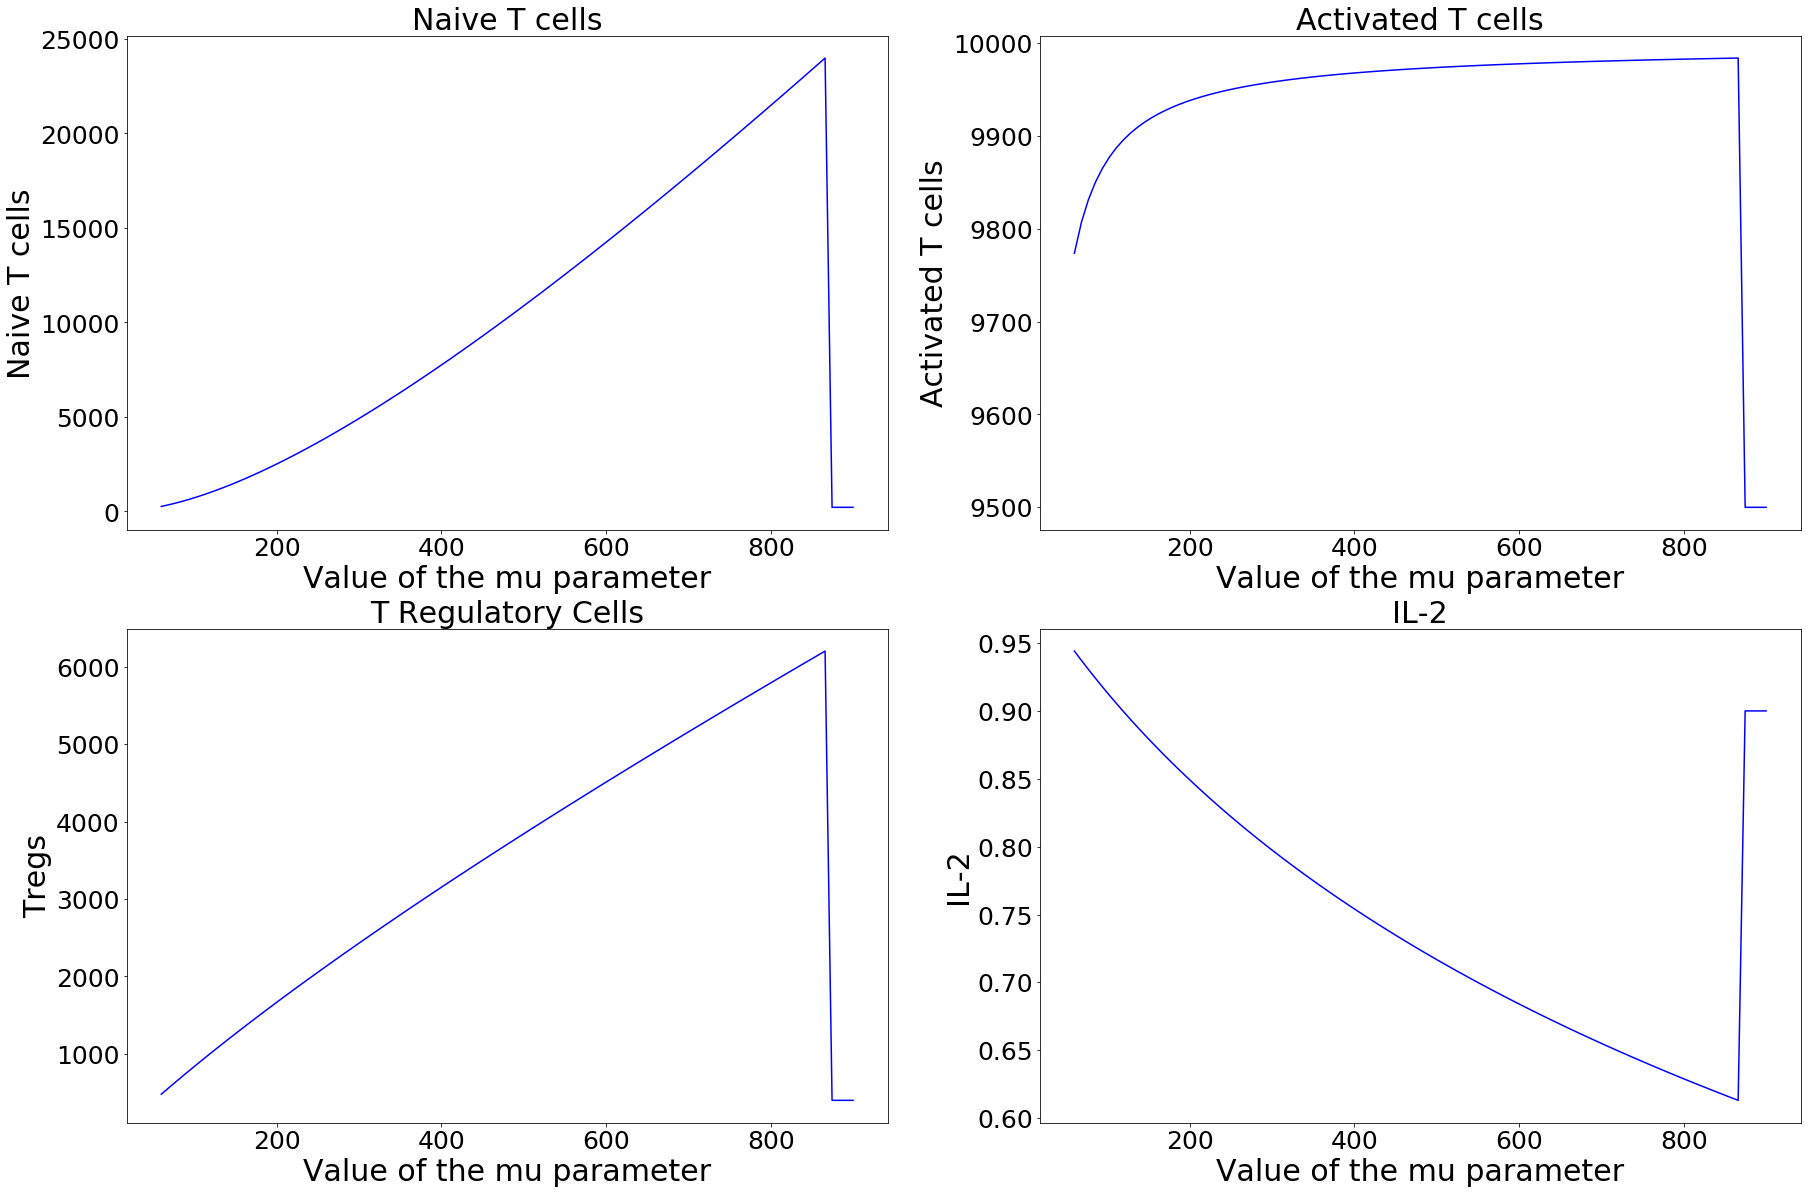

In [166]:
fig, Asiago = Speculator(60, 900, 100, 'mu', 0)

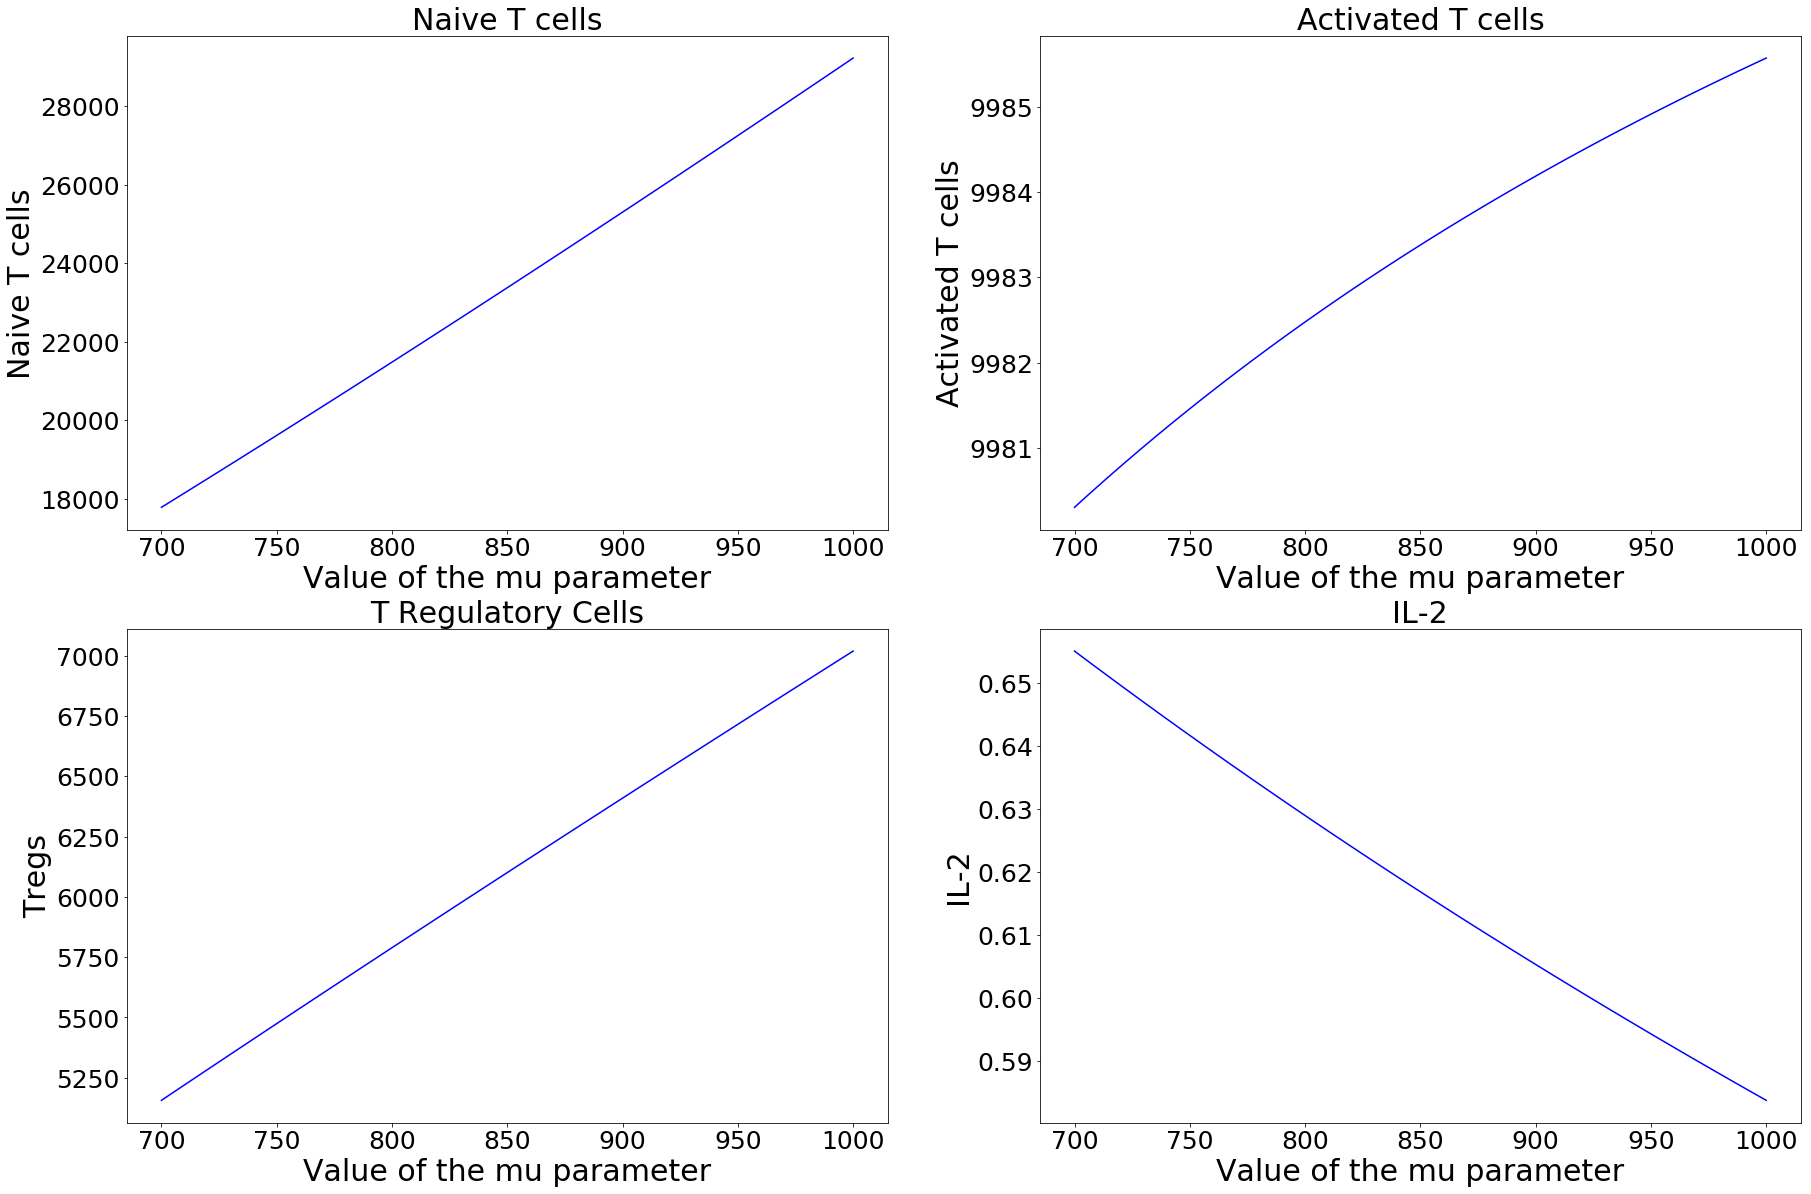

In [170]:
fig, Asiago1 = Speculator(700, 1000, 100, 'mu', 1)

In [172]:
#This is what was used as practice
ParameterSaver(Asiago1, 1000, 1)

In [21]:
def PlayTime(start, end, numTime, Ploc):
    ParSet = pd.read_csv("Parameters.csv")    
    Parm = ParSet.iloc[Ploc, 0:18]
    
    #Equilibrium points
    w0 = ParSet.iloc[Ploc, 20:24]
    w0 = [w0[0], w0[1], w0[2], w0[3]]
    #To get it away from the found eqilibrium point
    w0 = [x / 3 for x in w0]
    
    # time points
    t = np.linspace(start,end,num=numTime,endpoint=True)

    # solve ODE
    dyn = odeint(ModelV4,w0,t, args=(Parm,))
    
    #Creating a DF for my data, to plot
    Cells = pd.DataFrame(dyn, columns = ['N', 'T', 'R', 'I'])
    Cells['time'] = t
    
    fig = plt.figure(figsize=(13,13))

    #Naive
    ax1 = fig.add_subplot(321)
    ax1.plot(Cells['time'],Cells['N'] , 'b-')
    ax1.set_xlabel('time', fontsize = 13)
    ax1.set_ylabel('Naive T', fontsize = 13)
    ax1.set_title('Naive T Cells', fontsize = 13)
    ax1.tick_params(axis="x", labelsize=10)
    ax1.tick_params(axis="y", labelsize=10)
#     ax1.ticklabel_format(axis = "y", style='sci', scilimits=(0,0))


    # T
    ax2 = fig.add_subplot(322)
    ax2.plot(Cells['time'],Cells['T'],'b-')
    ax2.set_xlabel('time', fontsize = 13)
    ax2.set_ylabel('Activated T Cells', fontsize = 13)
    ax2.set_title('Activated T Cells', fontsize = 13)
    ax2.tick_params(axis="x", labelsize=10)
    ax2.tick_params(axis="y", labelsize=10)
#     ax2.ticklabel_format(axis = "y", style='sci', scilimits=(0,0))

    # Tregs
    ax4 = fig.add_subplot(323)
    ax4.plot(Cells['time'],Cells['R'],'b-')
    ax4.set_xlabel('time', fontsize = 13)
    ax4.set_ylabel('Tregs', fontsize = 13)
    ax4.set_title('T Regulatory Cells', fontsize = 13)
    ax4.tick_params(axis="x", labelsize=10)
    ax4.tick_params(axis="y", labelsize=10)
#     ax4.ticklabel_format(axis = "y", style='sci', scilimits=(0,0))

    # IL-2
    ax3 = fig.add_subplot(324)
    ax3.plot(Cells['time'],Cells['I'],'b-')
    ax3.set_xlabel('time', fontsize = 13)
    ax3.set_ylabel('IL-2 Cytokines', fontsize = 13)
    ax3.set_title('IL-2 Cytokines', fontsize = 13)
    ax3.tick_params(axis="x", labelsize=10)
    ax3.tick_params(axis="y", labelsize=10)

    fig.subplots_adjust(top = 1.1)

    return [fig, Cells]

/home/jon/anaconda3/lib/python3.7/site-packages/scipy/integrate/odepack.py:236: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


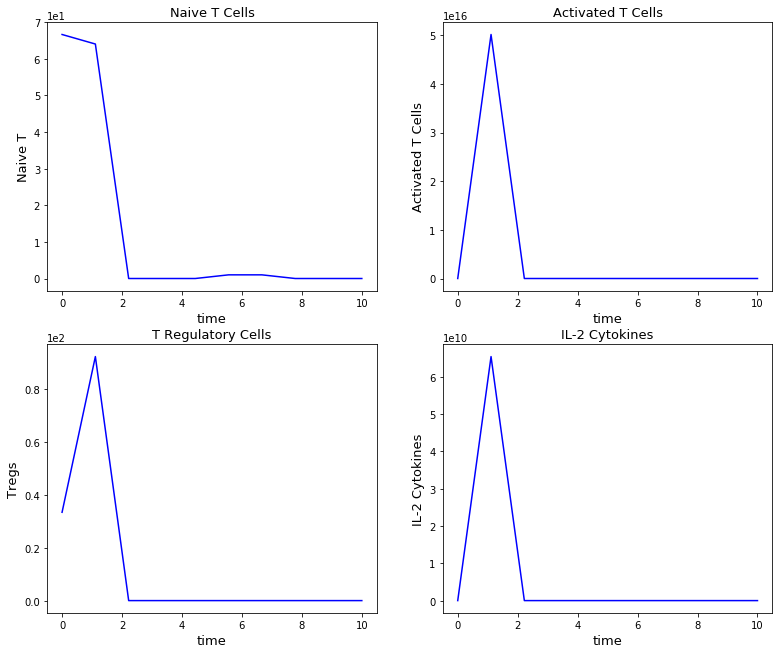

In [11]:
fig ,a = PlayTime(0, 10, 10, 7)

In [37]:
a.head(10)

,N,T,R,I,time
0,6.666667e+01,1.666667e+04,3.333333e+01,3.333333e+03,0.000000
1,6.087645e+01,6.703326e+16,1.001614e+02,3.308953e+10,0.050505
2,6.947541e-310,1.853697e-226,6.947541e-310,6.947541e-310,0.101010
3,3.118308e-135,6.947541e-310,6.947541e-310,6.908472e-230,0.151515
4,6.947595e-310,6.947541e-310,-3.360352e+152,6.947595e-310,0.202020
5,6.947541e-310,1.336055e-265,6.947541e-310,6.947541e-310,0.252525
6,-3.678669e+14,6.947541e-310,6.947541e-310,-4.064895e-66,0.303030
7,6.947541e-310,6.947541e-310,1.006128e+242,6.947593e-310,0.353535
8,6.947541e-310,1.788744e+249,6.947595e-310,6.947541e-310,0.404040
9,3.480348e-78,6.947541e-310,6.947541e-310,-3.739739e-37,0.454545


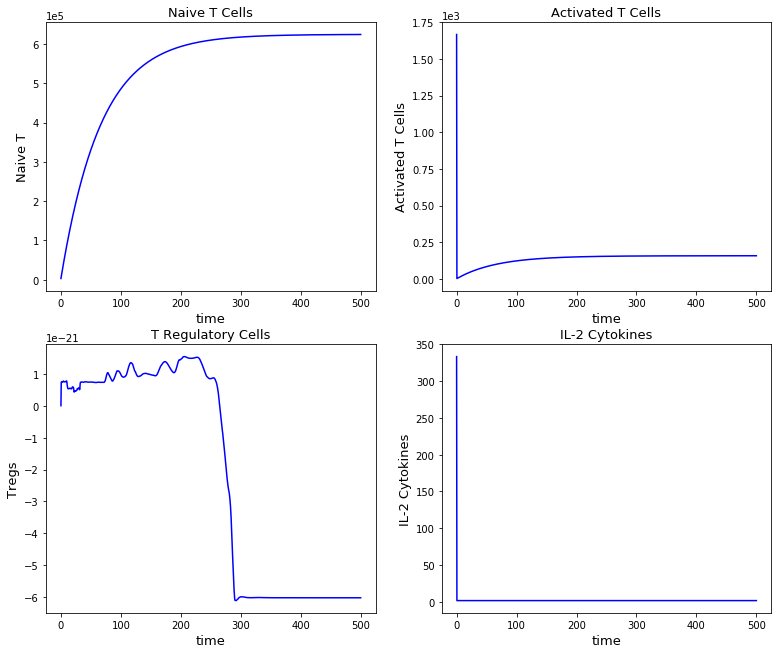

In [22]:
fig ,b = PlayTime(0, 500,1000, 10) 

In [9]:
255/1102

0.23139745916515425

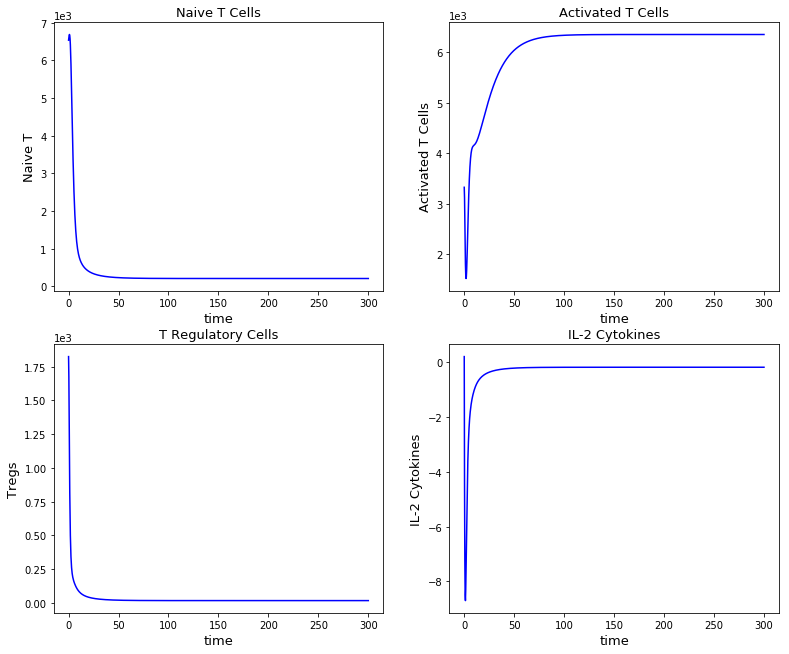

In [25]:
fig ,a = PlayTime(0, 300, 1000, 1)